In [1]:
# import required libraries
import torch
import torch.nn as nn
import torch.nn.functional as f
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import csv
import torchvision.transforms as transforms

#set seed for consistency and reproducibility
torch.manual_seed(123)
if torch.cuda.is_available:
  torch.cuda.manual_seed_all(1234)

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Data Augmentation has been performed to increase accuracy

In [3]:
# transformation for test data - nomalizing test data
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# transformation for train data 
train_transform = transforms.Compose([
    transforms.RandomRotation(10), # Add random rotation with 10 degrees
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1), # Add color jitter
    transforms.RandomHorizontalFlip(), #apply horizontal flipping
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create CIFAR-10 train dataset with updated data augmentation
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=train_transform, download=True)

# Create CIFAR-10 test dataset 
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=test_transform, download=True)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False)


100%|██████████| 170498071/170498071 [00:13<00:00, 12723884.61it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        #in_planes = input chanel size
        #planes = output chanel size
        #convolution later 1
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        #batch norm 1
        self.bn1 = nn.BatchNorm2d(planes)
        #convolution layer 2
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        #batch norm 2
        self.bn2 = nn.BatchNorm2d(planes)

        #skip connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    #forward pass of res-net
    def forward(self, x):
        out = f.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = f.relu(out)
        return out


In [5]:
#to edit the number of channels
channels = [32, 64, 128, 256]

- Here the averge pool layer has been removed and the parameters for the linear layer have been adjusted accordingly
- Drop out layer has also been added for regularization

In [6]:
class ResNet(nn.Module):
    def __init__(self, channels, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = channels[0]
        dropout_probability = 0.2
        self.conv1 = nn.Conv2d(3, channels[0], kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(channels[0])
        self.layer1 = self._make_layer(block, channels[0], num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, channels[1], num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, channels[2], num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, channels[3], num_blocks[3], stride=2)
        self.linear = nn.Linear(channels[3]*4*4, num_classes)

        # Dropout layer
        self.dropout = nn.Dropout(dropout_probability)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes 
        return nn.Sequential(*layers)

    def forward(self, x):
        out = f.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        # comment the line below to remove dropout layer
        #out = self.dropout(out)
        out = self.layer3(out)
        out = self.layer4(out)
        # out = f.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)

        # Apply dropout
        out = self.dropout(out)

        out = self.linear(out)
        return out

In [7]:
def ResNet18():
    return ResNet(channels, BasicBlock, [2, 2, 2, 2])

5 million = 5,000,000

In [8]:
# Create an instance of ResNet18
model = ResNet18()
model.to(device)

# Count the number of parameters
num_params = sum(p.numel() for p in model.parameters())
print("Number of parameters: ", num_params)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)
#uncomment the below line for lr scheduling
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)


Number of parameters:  2836010


In [9]:
def train_model(epoch):
  # num_batches = torch.ceil(torch.tensor(len(train_dataset)/100)).item()
  model.train()
  train_acc = 0
  epoch_loss = 0
  for i, (images, labels) in enumerate(train_loader):
      images = images.to(device)
      labels = labels.to(device)
      # print(train_loader, len(train_loader))
      # Forward pass
      output = model(images)
      loss = criterion(output, labels)
      # acc = calculate_accuracy(output, labels)
      _, predicted = torch.max(output.data, 1)
      # Backward and optimize
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      # epoch_acc += acc
      train_acc += (labels == predicted).sum().item()
      epoch_loss += loss.item()
       

  print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}, Accuracy: {train_acc / len(train_dataset)}')
  return round((train_acc / len(train_dataset))*100,2)

In [10]:
# Test the model
def model_eval(best_acc):
  model.eval()
  with torch.no_grad():
      correct = 0
      total = 0
      for images, labels in test_loader:
          images = images.to(device)
          labels = labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  # Print the accuracy
  accuracy = 100 * correct / total
  print(f'Test Accuracy: {accuracy:.2f}%')
  if accuracy>best_acc:
    # Save the model checkpoint
    torch.save(model.state_dict(), 'resnet.ckpt')
  return accuracy

In [11]:
# Training loop
num_epochs = 35
best_acc = 0
train_accuracies = []
test_accuracies = []
for epoch in range(num_epochs):
  train_accuracies.append(train_model(epoch))
  #if (epoch+1)%5==0:
  best_acc = max(best_acc, model_eval(best_acc))
  test_accuracies.append(best_acc)
  # scheduler.step() #uncomment while implementing lr scheduling


Epoch [1/35], Loss: 1.7411, Accuracy: 0.38376
Test Accuracy: 52.68%
Epoch [2/35], Loss: 1.2470, Accuracy: 0.55534
Test Accuracy: 63.55%
Epoch [3/35], Loss: 1.0098, Accuracy: 0.64538
Test Accuracy: 70.84%
Epoch [4/35], Loss: 0.8640, Accuracy: 0.6955
Test Accuracy: 72.73%
Epoch [5/35], Loss: 0.7693, Accuracy: 0.73294
Test Accuracy: 75.20%
Epoch [6/35], Loss: 0.7007, Accuracy: 0.75838
Test Accuracy: 76.90%
Epoch [7/35], Loss: 0.6430, Accuracy: 0.77734
Test Accuracy: 78.60%
Epoch [8/35], Loss: 0.6038, Accuracy: 0.79196
Test Accuracy: 80.92%
Epoch [9/35], Loss: 0.5559, Accuracy: 0.80558
Test Accuracy: 83.03%
Epoch [10/35], Loss: 0.5238, Accuracy: 0.81946
Test Accuracy: 81.81%
Epoch [11/35], Loss: 0.4972, Accuracy: 0.82736
Test Accuracy: 84.27%
Epoch [12/35], Loss: 0.4704, Accuracy: 0.83608
Test Accuracy: 84.67%
Epoch [13/35], Loss: 0.4520, Accuracy: 0.84444
Test Accuracy: 85.28%
Epoch [14/35], Loss: 0.4303, Accuracy: 0.85186
Test Accuracy: 85.55%
Epoch [15/35], Loss: 0.4136, Accuracy: 0.856

[38.38, 55.53, 64.54, 69.55, 73.29, 75.84, 77.73, 79.2, 80.56, 81.95, 82.74, 83.61, 84.44, 85.19, 85.68, 86.53, 86.66, 87.27, 87.8, 88.51, 88.67, 88.99, 89.27, 89.75, 90.24, 90.22, 90.67, 91.01, 91.31, 91.4, 91.55, 91.77, 92.15, 92.21, 92.71]
[52.68, 63.55, 70.84, 72.73, 75.2, 76.9, 78.6, 80.92, 83.03, 83.03, 84.27, 84.67, 85.28, 85.55, 85.55, 85.78, 87.02, 87.4, 87.4, 87.4, 88.32, 88.32, 88.48, 88.9, 89.08, 89.08, 89.08, 89.37, 89.37, 89.37, 89.37, 89.46, 89.46, 89.46, 89.68]


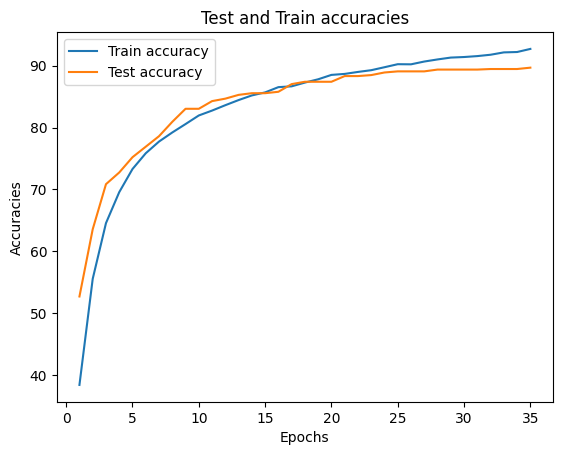

<Figure size 640x480 with 0 Axes>

In [20]:
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import numpy as np

# Generate two arrays for comparison
x = np.arange(1, 36) # Array of x values
y1 =  train_accuracies
y2 = test_accuracies
# print(len(y1))
# print(len(y2))
print(y1)
print(y2)

# Create the line graph
plt.plot(x, y1, label='Train accuracy')
plt.plot(x, y2, label='Test accuracy')

loc = plticker.MultipleLocator(base=5.0) # this locator puts ticks at regular intervals
plt.gca().xaxis.set_major_locator(loc)

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracies')
plt.title('Test and Train accuracies')

# Add a legend
plt.legend()

# Show the plot
plt.show()

# Save the graph as a PNG image
plt.savefig('graph.png')